In [ ]:
!wget https://www.kaggle.com/api/v1/datasets/download/atharvadumbre/indian-sign-language-islrtc-referred

In [ ]:
!unzip indian-sign-language-islrtc-referred

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VAL_SPLIT = 0.2

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=VAL_SPLIT,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    "original_images",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    "original_images",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

NUM_CLASSES = train_generator.num_classes
print("Detected classes:", NUM_CLASSES)

Found 28800 images belonging to 36 classes.
Found 7200 images belonging to 36 classes.
Detected classes: 36


In [5]:
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze backbone
for layer in base_model.layers:
    layer.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)

outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [8]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        "vgg16_best.keras",
        monitor="val_loss",
        save_best_only=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6
    )
]

In [9]:
history_stage1 = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 495s 533ms/step - accuracy: 0.3436 - loss: 2.4723 - val_accuracy: 0.6451 - val_loss: 1.0551 - learning_rate: 0.0010
Epoch 2/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 472s 525ms/step - accuracy: 0.8200 - loss: 0.5360 - val_accuracy: 0.6783 - val_loss: 1.0638 - learning_rate: 0.0010
Epoch 3/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 478s 532ms/step - accuracy: 0.8847 - loss: 0.3454 - val_accuracy: 0.7029 - val_loss: 0.9960 - learning_rate: 0.0010
Epoch 4/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 473s 525ms/step - accuracy: 0.9023 - loss: 0.2998 - val_accuracy: 0.7290 - val_loss: 0.8717 - learning_rate: 0.0010
Epoch 5/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 471s 523ms/step - accuracy: 0.9134 - loss: 0.2631 - val_accuracy: 0.7267 - val_loss: 0.8912 - learning_rate: 0.0010
Epoch 6/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 475s 527ms/step - accuracy: 0.9229 - loss: 0.2363 - val_accuracy: 0.7204 - val_loss: 0.9965 - learning_rate: 0.0010
Epoch 7/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 481s 535ms/step - accura

In [10]:
import numpy as np

validation_generator.reset()
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes
class_names = list(validation_generator.class_indices.keys())

225/225 ━━━━━━━━━━━━━━━━━━━━ 98s 430ms/step


In [11]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred_classes,
    target_names=class_names
))

              precision    recall  f1-score   support

           0       0.75      0.95      0.84       200
           1       0.92      0.87      0.89       200
           2       0.33      0.43      0.38       200
           3       0.64      0.71      0.67       200
           4       0.59      0.48      0.53       200
           5       0.63      0.72      0.67       200
           6       0.50      0.56      0.53       200
           7       0.62      0.44      0.52       200
           8       0.86      0.54      0.66       200
           9       0.64      0.49      0.56       200
           A       0.98      0.97      0.98       200
           B       1.00      0.99      1.00       200
           C       0.94      0.85      0.90       200
           D       0.82      0.94      0.88       200
           E       0.97      0.52      0.67       200
           F       0.91      0.89      0.90       200
           G       0.84      1.00      0.91       200
           H       0.90    

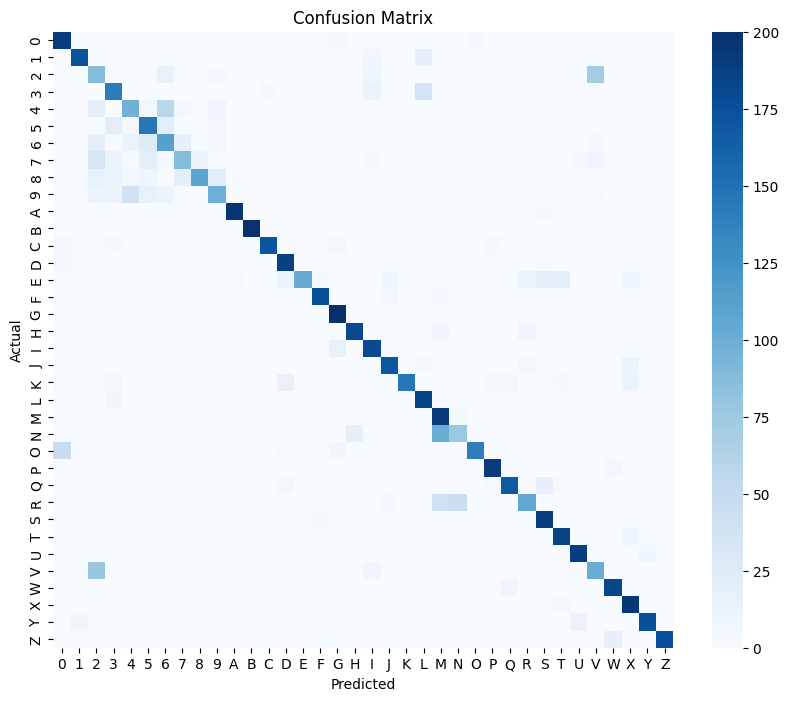

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()